Setup

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import sys

from datetime import datetime
from itertools import combinations
from openai import OpenAI

In [2]:
models = {
    'Gemma-V3-1B': 'google/gemma-3-1b-it:free',
    'DeepSeek-V3-0324': 'deepseek/deepseek-chat-v3-0324:free'
}

base_urls = {
    'OpenRouter': 'https://openrouter.ai/api/v1',
}

clients_details = [
    {
        'base_url': base_urls['OpenRouter'],
        'api_key': "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"
    }, # zandiyeh1379
    {
        'base_url': base_urls['OpenRouter'],
        'api_key': "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"
    }, # oibf7950
    {
        'base_url': base_urls['OpenRouter'],
        'api_key': "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"
    },  # moein
]

clients = [
    OpenAI(
        base_url=client['base_url'],
        api_key=client['api_key']
    ) for client in clients_details
]

In [3]:
current_client_idx = 0
current_client = clients[current_client_idx]

def update_current_client():
  global current_client_idx, current_client
  current_client_idx = (current_client_idx + 1) % len(clients)
  current_client = clients[current_client_idx]

Social Network Creation

In [4]:
class Agent:
  def __init__(self, persona: dict):
    self.persona = persona

  def get_details(self):
    return ', '.join(f"{k}: {v}" for k, v in self.persona.items())

In [5]:
class SocialNetwork:
  def __init__(self, agents: list[Agent]):
    self.agents = agents
    self.network = self.__create_network()
    self.groups = []

  def __create_network(self):
    network = nx.Graph()
    network.add_nodes_from(range(len(self.agents)))
    return network

  def draw_network(self):
    nx.draw(self.network, with_labels=True)
    plt.show()

  def create_group(self, members: list[int], model: str):
    connections = list(combinations(members, 2))
    self.network.add_edges_from(connections)

    members = [self.agents[member] for member in members]
    group = Group(members, model)
    self.groups.append(group)

    return group

In [11]:
class Group:
  def __init__(self, members: list[Agent], model: str):
    self.members = members
    self.model = model
    self.chats = []

  def add_chat(self, member: Agent, message: str):
    chat = {'sender': member, 'message': message}
    self.chats.append(chat)

  def get_members_details(self, indices: list[int]):
    return '\n'.join(self.members[i].get_details() for i in indices)

  def print_chats_history(self):
    for chat in self.chats:
      print('----------------------------------------------')
      print(f"Sender: {chat['sender'].persona['Name']}\n{chat['message']}")
      print('----------------------------------------------\n\n')

  def get_list_messages(self, member: Agent):
    return [chat['message'] for chat in self.chats if chat['sender'] == member]

  def send_message(self, sender_idx: int, prompt_start: str):
    sender_details = self.get_members_details([sender_idx])

    receivers_indices = [j for j in range(len(self.members)) if j != sender_idx]
    receivers_details = self.get_members_details(receivers_indices)

    prompt_intro = f"""You are {sender_details}, engaging in a friendly conversation with \n{receivers_details}.
      \nBelow is the chat history so far:\n{self.get_chats_history()}\n\n"""

    messages = [
        {
            'role': 'user',
            'content': prompt_intro + prompt_start
        }
    ]

    def get_client_response():
      return current_client.chat.completions.create(
          model=self.model,
          messages=messages,
      )

    num_failed_tries = 0
    response = get_client_response()

    while response.id is None:
      num_failed_tries += 1
      if num_failed_tries > len(clients):
        sys.exit('No response from any client')

      update_current_client()
      response = get_client_response()

    return response.choices[0].message.content.strip()

  def communicate(self, prompt_start: str, rounds: int):
    for _ in range(rounds):
      for sender_idx in range(len(self.members)):
        message = self.send_message(sender_idx, prompt_start)
        self.add_chat(self.members[sender_idx], message)

        print('----------------------------------------------')
        print(f"Sender: {self.members[sender_idx].persona['Name']}\n{message}")
        print('----------------------------------------------\n\n')

Social Media #1

In [7]:
persona_keys = ['Name', 'Gender', 'Age', 'Economic Status', 'Occupation']

personas = [
  ['Kayla', 'Female', 'Teen', 'Working Class', 'TikTok Influencer'],
  ['Morgan', 'Nonbinary', 'Adult', 'Upper-Middle', 'Corporate Lawyer'],
  ['Frank', 'Male', 'Elderly', 'Poor', 'Uber Driver'],
  ['Karen', 'Female', 'Middle-Aged', 'Middle Class', 'Politician (Controversial)'],
  ['Leo', 'Male', 'Young Adult', 'Lower Class', 'Activist (Environmental)']
]

agents = [Agent(dict(zip(persona_keys, persona))) for persona in personas]

In [8]:
social_network = SocialNetwork(agents)

group_0_1_2 = social_network.create_group([0, 1, 2], models['DeepSeek-V3-0324'])

In [9]:
prompt_start = "Please respond with only the next message that would naturally continue this conversation, based on your innate personality and communication style."

In [10]:
group_0_1_2.communicate(prompt_start, 10)

----------------------------------------------
Sender: Kayla
*adjusting phone to get good lighting* "Morgan, your job sounds so intense! I could never sit in an office all day—I’d die of boredom 😂 Frank, do you like driving for Uber? I feel like you’d meet so many weird people, that’s kinda cool tho!"
----------------------------------------------


----------------------------------------------
Sender: Morgan
*chuckles, loosening tie slightly* "Oh, Kayla, the office has its moments—like when a client tries to argue that ‘vibes’ are legally binding. Frank, I’d take your backseat stories over corporate jargon any day. What’s the wildest ride you’ve had?"
----------------------------------------------


----------------------------------------------
Sender: Frank
*leans back in the driver’s seat, scratching his scruffy chin with a grin* "Aw, you kids’d be surprised what folks say when they think you’re just part of the car! Had one fella last week sing showtunes the whole ride—off-key as

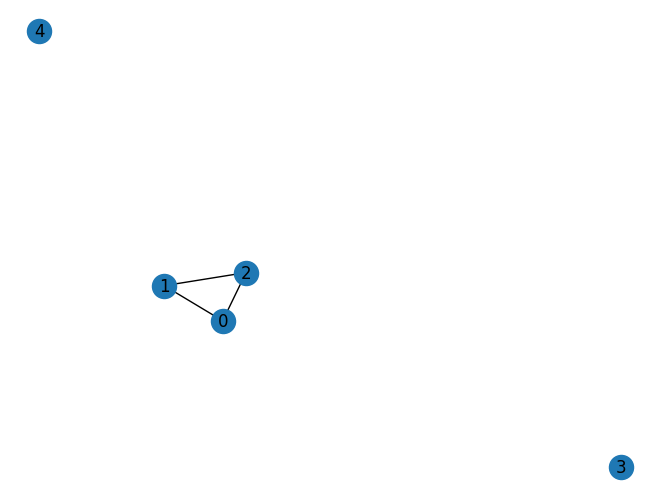

In [17]:
social_network.draw_network()

In [21]:
group_0_1_2.get_list_messages(group_0_1_2.members[0])

['*adjusting phone to get good lighting* "Morgan, your job sounds so intense! I could never sit in an office all day—I’d die of boredom 😂 Frank, do you like driving for Uber? I feel like you’d meet so many weird people, that’s kinda cool tho!"',
 '*adjusts phone angle again, giggling* "OMG Frank, that’s genius! I should totally do a ‘Uber Car Dance Challenge’—just hope the driver doesn’t hit a pothole mid-viral move 😂 Morgan, y’all gotta tell me more about these ‘vibes’ clients though—like, did they bring a mood board to court or somethin’? *grinning*"',
 '**Kayla:** *snorts laughing, nearly dropping phone* "PFFT—Frank, you’re not wrong! Karens in my comments be like ‘DoN’t QuIt YoUr DaY jOb’—JOKE’S ON THEM, this *is* my day job! 😂 Morgan, I’d pay to see you attempt my ‘Renegade’ tutorial though—giraffe vibes and all. Bet we could get Frank to honk the beat for us!" *grins, flipping hair dramatically*',
 '**Kayla:** *gasping dramatically, clutching her chest* "OMG, Frank, you\'re a gen